In [1]:
# Import 3rd party libraries
import os
import json
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from folium import Choropleth

# Configure Notebook
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_context("notebook")
import warnings
warnings.filterwarnings('ignore')

In [2]:
neighbourhoods = gpd.read_file('toronto_neighbourhoods.shp')
neighbourhoods = neighbourhoods[['geometry','FIELD_8']].rename(columns={'FIELD_8':'name'})
neighbourhoods['name'] = neighbourhoods['name'].str.split('(').str[0] # Splits by '(' and takes the first part before '(')
neighbourhoods=neighbourhoods.to_crs(epsg=26917)
# View GeoDataFrame
neighbourhoods.head()

,geometry,name
0,"POLYGON ((626071.503 4837537.756, 626151.708 4...",Wychwood
1,"POLYGON ((628032.302 4840233.689, 628139.346 4...",Yonge-Eglinton
2,"POLYGON ((629674.232 4837709.743, 629657.497 4...",Yonge-St.Clair
3,"POLYGON ((620320.085 4846288.688, 620352.534 4...",York University Heights
4,"POLYGON ((625714.291 4840359.316, 625680.263 4...",Yorkdale-Glen Park


In [3]:
ttc_delays = pd.read_csv('delays_combined.csv')
ttc_delays.head()

,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,2014-01-01,00:21,Wednesday,VICTORIA PARK STATION,MUPR1,55,60,W,BD,5111,NaN,NaN,NaN
1,2014-01-01,02:06,Wednesday,HIGH PARK STATION,SUDP,3,7,W,BD,5001,NaN,NaN,NaN
2,2014-01-01,02:40,Wednesday,SHEPPARD STATION,MUNCA,0,0,NaN,YU,0,NaN,NaN,NaN
3,2014-01-01,03:10,Wednesday,LANSDOWNE STATION,SUDP,3,8,W,BD,5116,NaN,NaN,NaN
4,2014-01-01,03:20,Wednesday,BLOOR STATION,MUSAN,5,10,S,YU,5386,NaN,NaN,NaN


In [4]:
ttc_delays = pd.read_csv('delays_combined.csv')
assaults=['SUAE','SUAP','SUSA','SUDP'] # All codes that replated to assault or disorder 
ttc_delays_assaults=ttc_delays[ttc_delays['Code'].isin(assaults)] # Filter by code
ttc_delays_assaults['Date']=pd.to_datetime(ttc_delays_assaults['Date'])
ttc_delays_assaults_2023=ttc_delays_assaults[ttc_delays_assaults['Date'].dt.year == 2023] #Filter to get data only for 2023
ttc_delays_assaults_2023['Hour'] = pd.to_datetime(ttc_delays_assaults_2023['Time'], errors='coerce').dt.hour
ttc_delays_assaults_2023.head()

,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Unnamed: 10,Unnamed: 11,Unnamed: 12,Hour
172974,2023-01-01,14:39,Sunday,DAVISVILLE STATION,SUDP,4,8,N,YU,5546,NaN,NaN,NaN,14
172977,2023-01-01,16:13,Sunday,SHEPPARD WEST STATION,SUDP,6,10,S,YU,5451,NaN,NaN,NaN,16
172981,2023-01-01,17:27,Sunday,GREENWOOD STATION,SUDP,9,13,W,BD,5371,NaN,NaN,NaN,17
172986,2023-01-01,20:37,Sunday,YONGE BD STATION,SUDP,3,8,E,BD,5056,NaN,NaN,NaN,20
172990,2023-01-01,22:19,Sunday,UNION STATION,SUDP,14,20,N,YU,6086,NaN,NaN,NaN,22


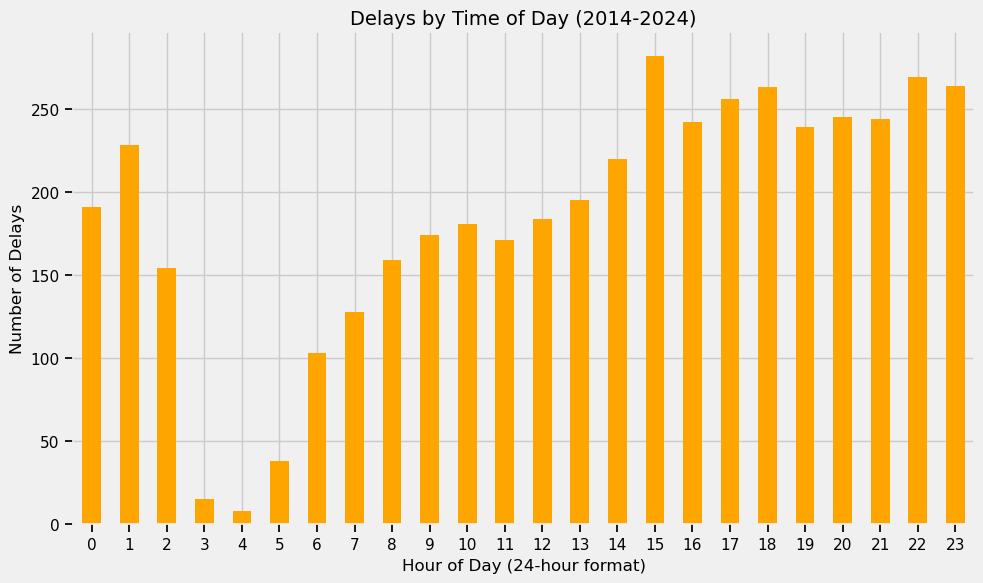

In [5]:
time_of_day_delays = ttc_delays_assaults_2023.groupby('Hour').size()
plt.figure(figsize=(10, 6))
time_of_day_delays.plot(kind='bar', color='orange')
plt.title('Delays by Time of Day (2014-2024)', fontsize=14)
plt.xlabel('Hour of Day (24-hour format)', fontsize=12)
plt.ylabel('Number of Delays', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
     


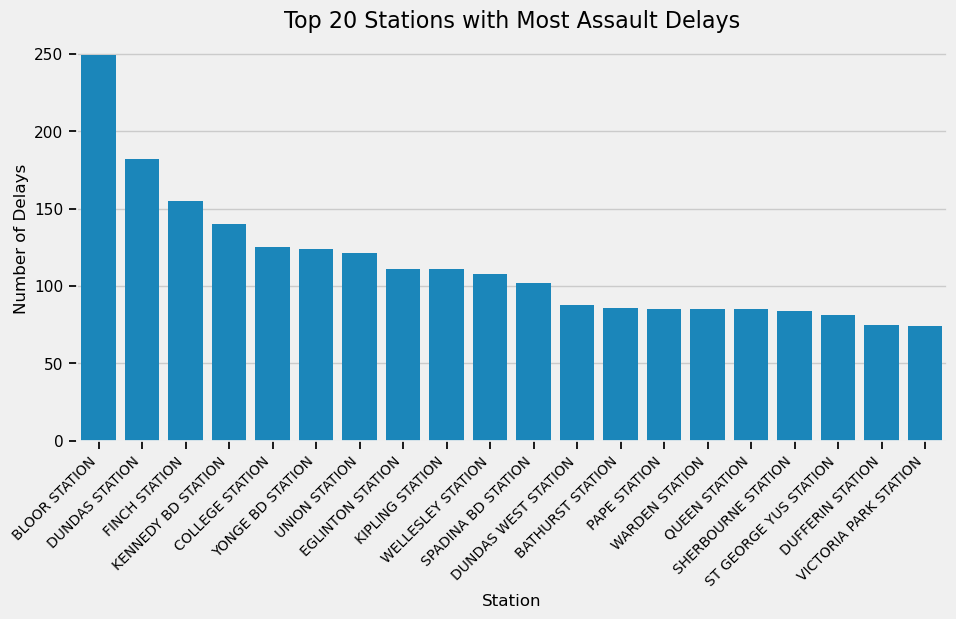

In [6]:
stations_delays = ttc_delays_assaults_2023.groupby('Station').size().sort_values(ascending=False).to_frame()
stations_delays=stations_delays.rename(columns={0:'Assaults Count'})
top_20_stations = stations_delays.head(20).reset_index()

plt.figure(figsize=(10,5))
sns.barplot(x=top_20_stations['Station'],y=top_20_stations['Assaults Count'])
plt.title('Top 20 Stations with Most Assault Delays', fontsize=16)
plt.xlabel('Station', fontsize=12)
plt.ylabel('Number of Delays', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)  
plt.show()

In [7]:
subway_stations = gpd.read_file('subway_stations.shp').to_crs(epsg=26917)
subway_stations=subway_stations[['STATION','geometry']]
subway_stations=subway_stations.rename(columns={'STATION':'Station'})
subway_stations.head(10)

,Station,geometry
0,Kipling,POINT (618101.613 4832636.3)
1,Islington,POINT (618990.613 4833544.113)
2,Royal York,POINT (620056.496 4833882.764)
3,Old Mill,POINT (621361.678 4834111.901)
4,Jane,POINT (622220.664 4834091.381)
5,Runnymede,POINT (622874.508 4834305.389)
6,High Park,POINT (623684.881 4834584.911)
7,Keele,POINT (624191.616 4834764.33)
8,Dundas West,POINT (624793.207 4834950.95)
9,Lansdowne,POINT (625578.442 4835178.398)


In [8]:
stations_delays.reset_index(inplace=True)
stations_delays

,Station,Assaults Count
0,BLOOR STATION,249
1,DUNDAS STATION,182
2,FINCH STATION,155
3,KENNEDY BD STATION,140
4,COLLEGE STATION,125
...,...,...
95,MCBRIAN BUILDING,1
96,ST CLAIR STAITON,1
97,OSSINGTON STATION(APPR,1
98,PLATFORM 2 FINCH,1


In [9]:
stations_delays['Station'] = stations_delays['Station'].str.lower()
subway_stations['Station']=subway_stations['Station'].str.lower()

stations_delays.head()

,Station,Assaults Count
0,bloor station,249
1,dundas station,182
2,finch station,155
3,kennedy bd station,140
4,college station,125


In [10]:
stations_delays['Station'] = stations_delays['Station'].str.replace(" station","").str.strip()
stations_delays.head()

,Station,Assaults Count
0,bloor,249
1,dundas,182
2,finch,155
3,kennedy bd,140
4,college,125


In [11]:
#Merge the top 20 stations with the geodata points of subway stations
stations_delays_geo = stations_delays.merge(subway_stations, on='Station', how='left') 
stations_delays_geo[stations_delays_geo['geometry'].isna()] #Check if there are stations that were not successfully merged due to difference in name

,Station,Assaults Count,geometry
0,bloor,249,None
3,kennedy bd,140,None
5,yonge bd,124,None
10,spadina bd,102,None
17,st george yus,81,None
20,vaughan mc,72,None
23,st george bd,67,None
29,st clair,59,None
33,sheppard west,54,None
34,spadina yus,54,None


In [12]:
subway_stations['Station'].unique()

array(['kipling', 'islington', 'royal york', 'old mill', 'jane',
       'runnymede', 'high park', 'keele', 'dundas west', 'lansdowne',
       'dufferin', 'ossington', 'christie', 'bathurst', 'spadina',
       'st. george', 'bay', 'bloor-yonge', 'sherbourne', 'castle frank',
       'broadview', 'chester', 'pape', 'donlands', 'greenwood', 'coxwell',
       'woodbine', 'main street', 'victoria park', 'warden', 'kennedy',
       'union', 'st. andrew', 'king', 'osgoode', 'queen', 'st. patrick',
       'dundas', "queen's park", 'college', 'wellesley', 'museum',
       'rosedale', 'summerhill', 'st. clair', 'davisville', 'eglinton',
       'lawrence', 'york mills', 'sheppard-yonge', 'north york centre',
       'finch', 'dupont', 'st clair west', 'eglinton west', 'glencairn',
       'lawrence west', 'yorkdale', 'wilson', 'downsview', 'bayview',
       'bessarion', 'leslie', 'don mills'], dtype=object)

In [16]:
stations_delays['Station'] = stations_delays['Station'].replace({
    'bloor': 'bloor-yonge', 
    'kennedy bd': 'kennedy',
    'yonge bd': 'bloor-yonge',
    'spadina bd':'spadina',
    'st george yus':'st. george',
    'st george bd':'st. george',
    'st clair':'st. clair',
    'spadina yus':'spadina',
    'st patrick':'st. patrick',
    'north york ctr':'north york centre',
    'pioneer village statio':'pioneer village',
    'st andrew':'st. andrew',
    'sheppard':'sheppard-yonge',
    'york university statio':'york university'})
stations_delays_filtered=stations_delays[stations_delays['Assaults Count']>2]
new_stations= {"Station": [
        "sheppard west",
        "pioneer village",
        "finch west",
        "york university",
        "downsview park",
        "highway 407",
        "vaughan mc"
    ],
    "Latitude": [43.7497, 43.7772, 43.7651, 43.7739, 43.7535, 43.7832, 43.7942],
    "Longitude": [-79.4619,-79.5103,-79.4910,-79.4998,-79.4790,-79.5237,-79.5275]
}
new_stations_gdf = gpd.GeoDataFrame(new_stations, 
                                          geometry=gpd.points_from_xy(new_stations['Longitude'],
                                                                      new_stations['Latitude']))
new_stations_gdf=new_stations_gdf[['Station','geometry']]
subway_stations = pd.concat([new_stations_gdf, subway_stations], ignore_index=True)
subway_stations

,Station,geometry
0,sheppard west,POINT (-79.462 43.75)
1,pioneer village,POINT (-79.51 43.777)
2,finch west,POINT (-79.491 43.765)
3,york university,POINT (-79.5 43.774)
4,downsview park,POINT (-79.479 43.754)
...,...,...
67,downsview,POINT (623789.424 4845232.839)
68,bayview,POINT (629762.504 4847231.368)
69,bessarion,POINT (630655.08 4847517.607)
70,leslie,POINT (631441.758 4847727.273)


In [18]:
stations_delays_geo = stations_delays_filtered.merge(subway_stations, on='Station', how='left') 
stations_delays_geo[stations_delays_geo['geometry'].isna()] #Check if there are stations that were not successfully merged due to difference in name

,Station,Assaults Count,geometry


In [20]:
stations_delays_gdf=gpd.GeoDataFrame(stations_delays_geo, geometry='geometry') #Convert data to geodata
stations_delays_gdf.set_crs(epsg=26917, inplace=True)
stations_delays_gdf.head()

,Station,Assaults Count,geometry
0,bloor-yonge,249,POINT (630136.965 4836575.675)
1,dundas,182,POINT (630555.233 4834978.387)
2,finch,155,POINT (627505.402 4848639.783)
3,kennedy,140,POINT (639834.126 4843622.665)
4,college,125,POINT (630370.915 4835534.587)


In [22]:
#Function that checks the station if in the neighborhood, if there are several it sums the assaults and returns single value
def calculate_assaults(row, points_gdf):
    # Filter points within the current polygon
    points_within = points_gdf[points_gdf.within(row.geometry)]
    # Sum the Total Assaults for these points
    return points_within['Assaults Count'].sum()

# Apply the function to each row in the neighborhoods GeoDataFrame
neighbourhoods['Assaults'] = neighbourhoods.apply(
    lambda row: calculate_assaults(row, stations_delays_gdf), axis=1
)

# Result
neighbourhoods

,geometry,name,Assaults
0,"POLYGON ((626071.503 4837537.756, 626151.708 4...",Wychwood,0
1,"POLYGON ((628032.302 4840233.689, 628139.346 4...",Yonge-Eglinton,170
2,"POLYGON ((629674.232 4837709.743, 629657.497 4...",Yonge-St.Clair,0
3,"POLYGON ((620320.085 4846288.688, 620352.534 4...",York University Heights,0
4,"POLYGON ((625714.291 4840359.316, 625680.263 4...",Yorkdale-Glen Park,94
...,...,...,...
135,"POLYGON ((641302.092 4843448.098, 641297.809 4...",Kennedy Park,140
136,"POLYGON ((628713.653 4833925.535, 628698.164 4...",Kensington-Chinatown,0
137,"POLYGON ((616628.923 4840623.278, 616634.524 4...",Kingsview Village-The Westway,0
138,"POLYGON ((619601.263 4833636.747, 619589.12 48...",Kingsway South,63


In [24]:
plot_geography = neighbourhoods.to_crs(epsg=4326)[['name', 'geometry']]
plot_geography = plot_geography.set_index('name')
plot_data = neighbourhoods[['name', 'Assaults']]
plot_geography.head()

,geometry
name,
Wychwood,"POLYGON ((-79.43592 43.68015, -79.43492 43.680..."
Yonge-Eglinton,"POLYGON ((-79.41096 43.70408, -79.40962 43.704..."
Yonge-St.Clair,"POLYGON ((-79.39119 43.68108, -79.39141 43.680..."
York University Heights,"POLYGON ((-79.50529 43.75987, -79.50488 43.759..."
Yorkdale-Glen Park,"POLYGON ((-79.43969 43.70561, -79.44011 43.705..."


In [26]:
from folium import Marker

In [28]:
map_0 = folium.Map(location=[43.6426, -79.3871], 
                 tiles='cartodbpositron',
                 zoom_start=10)
# Add a choropleth map to the base map
Choropleth(geo_data=plot_geography.__geo_interface__, 
           columns=['name', 'Assaults'],
           data=plot_data, 
           key_on='feature.id', 
           fill_color='YlOrRd', 
           legend_name='Number of Assaults'
          ).add_to(map_0)

map_0

In [32]:
neighbourhoods_violent=neighbourhoods[neighbourhoods['Assaults']>0].sort_values(by='Assaults', ascending=False)
neighbourhoods_violent_10=neighbourhoods_violent.head(10)

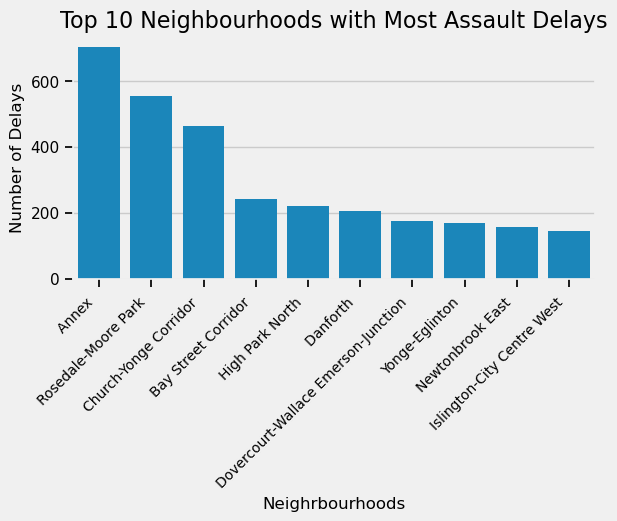

In [34]:
plt.figure(figsize=(6,3))
sns.barplot(x=neighbourhoods_violent_10['name'],y=neighbourhoods_violent_10['Assaults'])
plt.title('Top 10 Neighbourhoods with Most Assault Delays', fontsize=16)
plt.xlabel('Neighrbourhoods', fontsize=12)
plt.ylabel('Number of Delays', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)  
plt.show()